In [1]:
from optionCombo import optionModel,preInit

# Collect Deribit option data

In [2]:
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import random
import time
from tqdm.notebook import tqdm
#most of the code comes from this repo https://github.com/schepal/deribit_data_collector/blob/master/deribit_data.py

def request_get(url):
    while True:
        try:
            page = requests.get(url)
            return page.json()['result']
        except:time.sleep(random.randint(1,5))
        
def get_options_list():
    data = {'currency': currency, 'kind': 'option'}
    r = requests.get(url + 'get_instruments', data)
    df = pd.DataFrame(r.json()['result'])
    cols = ['expiration_timestamp', 'option_type', 'instrument_name', 'strike']
    return df[cols]
def get_option_urls():
    url_storage = []
    options_list = get_options_list()
    request_url = url + 'get_order_book?instrument_name='
    for option in range(len(options_list)):
        data = request_url + options_list.instrument_name.values[option]
        url_storage.append(data)
    return url_storage
def collect_clean_data():

    raw_data = []
    pool = ThreadPoolExecutor(max_workers=20)
    print("Collecting data...")
    urls = get_option_urls()
    for asset in tqdm(pool.map(request_get,urls ),total=len(urls)):
        raw_data.append(asset)
    data = pd.DataFrame(raw_data)

    option_data = data
    option_data['infos'] = option_data['instrument_name'].apply(lambda x: x.split('-'))
    option_data['expiration'] = option_data['infos'].apply(
        lambda x: pd.to_datetime(x[1]))  # pd.to_datetime(option_data['expiration'])#
    option_data['is_call'] = option_data['infos'].apply(lambda x: x[-1])
    option_data['K'] = option_data['infos'].apply(lambda x: x[-2])
    option_data['ticker'] = option_data['infos'].apply(lambda x: x[0])
    option_data['askIv'] = option_data['ask_iv'] / 100  # option_data['askIV']#
    option_data['bidIv'] = option_data['bid_iv'] / 100  # option_data['bidIV']#
    option_data[['K', 'bidIV', 'askIV']] = option_data[['K', 'bidIv', 'askIv']].astype('float')

    option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))

    option_data = option_data[['is_call','K','askIV','bidIV','expiry','expiration']]
    expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


    return option_data,expirList

In [4]:
global currency
global url
currency = 'BTC'
url = 'https://www.deribit.com/api/v2/public/'
option_data,expirList = collect_clean_data()

  0%|          | 0/752 [00:00<?, ?it/s]

In [5]:
expirList

<DatetimeArray>
['2023-07-18 00:00:00', '2023-07-19 00:00:00', '2023-07-20 00:00:00',
 '2023-07-21 00:00:00', '2023-07-28 00:00:00', '2023-08-04 00:00:00',
 '2023-08-25 00:00:00', '2023-09-29 00:00:00', '2023-12-29 00:00:00',
 '2024-03-29 00:00:00', '2024-06-28 00:00:00']
Length: 11, dtype: datetime64[ns]

In [6]:
'''
choose a expiry date, doesn't support mutiple expiry dates at the moment
'''
expirDate = '2023-07-21 00:00:00'

In [7]:
'''
The option DataFrame should have the following structure:
'''
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,27000.0,0.0000,0.0000,-0.001767,2023-07-18
1,P,27000.0,5.5877,0.0000,-0.001767,2023-07-18
2,C,27500.0,0.0000,0.0000,-0.001767,2023-07-18
3,P,27500.0,5.4873,0.0000,-0.001767,2023-07-18
4,C,28000.0,0.0000,0.0000,-0.001767,2023-07-18
...,...,...,...,...,...,...
747,P,95000.0,4.9895,0.0000,0.946178,2024-06-28
748,C,100000.0,0.6890,0.6679,0.946178,2024-06-28
749,P,100000.0,4.9970,0.0000,0.946178,2024-06-28
750,C,120000.0,0.7223,0.6997,0.946178,2024-06-28


# Collect price data, this is used for determine asset price range

In [8]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [9]:
pricedata = fetchprice('BTCUSDT')

In [10]:
'''
The price DataFrame should have the following structure:
'''
pricedata

,Timestamp,open,high,low,close,volume
0,2022-12-11 13:30:00,17162.71,17163.32,17140.02,17150.86,1818.23682
1,2022-12-11 13:45:00,17150.86,17159.61,17127.96,17157.50,3127.95880
2,2022-12-11 14:00:00,17157.21,17159.58,17136.40,17146.80,2578.42902
3,2022-12-11 14:15:00,17146.59,17154.68,17130.10,17140.17,1869.07015
4,2022-12-11 14:30:00,17140.53,17149.51,17137.53,17149.17,1236.86272
...,...,...,...,...,...,...
20995,2023-07-18 06:15:00,30068.00,30097.09,30000.00,30047.12,323.24279
20996,2023-07-18 06:30:00,30047.11,30047.12,29930.55,29966.48,566.45515
20997,2023-07-18 06:45:00,29966.49,30015.32,29921.54,29988.62,350.93441
20998,2023-07-18 07:00:00,29988.61,30036.00,29969.06,30028.01,327.24541


In [11]:
spotPrice =  pricedata.close.values[-1]

In [12]:
"""
built in function to calculate expeted range
"""
bound = preInit.calRange(pricedata,expirDate,interval_width=2.5)

In [13]:
bound

(27527.745148309295, 33036.31844391873)

In [14]:
preInit.calRange(pricedata,expirDate,interval_width=1)

(29076.152716934437, 31277.01805987669)

In [16]:
'''

This section of the code is responsible for the pre-computation step. It prepares and computes the 
necessary data for further calculations related to the option combinations.

In this step, you need to select the expiry date for your option strategy and provide the required 
option data and price bound.

'''

preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data,spotPrice = spotPrice,Bound = (29076.152716934437, 33036.31844391873), BoundExtend=1.2, strikePriceRange=0.3)

In [17]:
'''
This section of the code is responsible for iterating through all possible option combinations. In 
the "optiontypes" parameter, a two-dimensional list should be provided, where each element represents 
a call option (1) or a put option (-1). For example, [[1,1,1],[-1,-1,1,1]] indicates that there are 
three call options followed by two put options and two call options.

The "tradetypes" parameter determines whether to sell or buy the corresponding options. For instance, 
if "optiontypes" is [[1,1,1]], the "tradetypes" should be [[1,-1,1]] or [[[1,-1,1],[1,1,1]]]. 
By default, "tradetypes" is set to None, which includes all possible combinations.

The "maxquantity" parameter represents the maximum quantity allowed for a single option trade amount.
'''

model = optionModel.option_model(price, joined1,preOption,optiontypes = [[-1,-1,1,1]],tradetypes=None, maxquantity=4)  # Init
df = model.options_model_finder()                                                                           # start looping

100%|███████████████████████████████████████████████████████████████████████| 1215076/1215076 [20:49<00:00, 972.83it/s]


In [18]:
'''

The output of the code snippet contains all the possible combinations based on the provided 
parameters. You have the flexibility to filter the results according to your specific requirements.

'''
df

,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,wd,bd,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium,minReward
0,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_1__P_26500_1__C_26500_1__C_27000_1,0.318339,0.733333,2.645473,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,1.187622,1.457657,1.499535,-29.900300,95.260921,6824.9538,-2172.6484
1,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_1__P_26500_1__C_27000_1__C_27500_1,0.374336,0.700000,2.624566,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,1.120682,1.472353,1.930991,-37.750915,110.515815,5837.4860,-2185.1806
2,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_1__P_26500_1__C_27500_1__C_28000_1,0.454632,0.700000,2.582191,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,1.053632,1.489030,2.549737,-48.492703,127.454366,4863.3355,-2211.0301
3,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_1__P_26500_1__C_28000_1__C_28500_1,0.575404,0.700000,2.537173,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,0.999010,1.495923,3.393145,-62.542020,145.343385,3891.4751,-2239.1697
4,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_1__P_26500_1__C_28500_1__C_29000_1,0.778799,0.700000,2.448682,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,0.944345,1.498979,4.434128,-79.325902,162.880099,2948.9309,-2296.6255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215071,"[30027.17, [0.006451885720256215, 0.0064518857...",P_30000_-4__P_30500_-4__C_31500_-4__C_32000_-3,2.042651,0.600000,0.489560,1.15,29076.1527,0.85,30578.2845,2.354938,0.000000,0.062086,7.039521,-26.198131,272.858943,500.313968,3892.1146,-5498.6638
1215072,"[30027.17, [0.006451885720256215, 0.0064518857...",P_30000_-4__P_30500_-4__C_32000_-4__C_32500_-3,2.079798,0.700000,0.480816,1.15,29076.1527,0.85,30578.2845,2.354938,0.000000,0.247360,6.951836,-25.158678,260.318153,469.220355,3786.9198,-5603.8586
1215073,"[30027.17, [0.006451885720256215, 0.0064518857...",P_30000_-4__P_30500_-4__C_32500_-4__C_33000_-3,2.096428,0.800000,0.477002,1.15,29076.1527,0.85,30578.2845,2.354938,0.000000,0.484474,6.809108,-23.309439,239.396623,432.753727,3733.8932,-5656.8852
1215074,"[30027.17, [0.006451885720256215, 0.0064518857...",P_30000_-4__P_30500_-4__C_33000_-4__C_33500_-3,2.106119,0.800000,0.474807,1.15,29076.1527,0.85,30578.2845,2.354938,0.000000,0.738864,6.672565,-20.833448,213.862275,391.836333,3704.7829,-5685.9955


In [19]:
'''

The output of the code snippet contains all the possible combinations based on the provided 
parameters. You have the flexibility to filter the results according to your specific requirements.

'''
df['v/t'] = abs(df['mean_vega']/abs(df['mean_theta']))
df['bb'] = df['probal']*df['RR']/df['maxRisk']/df['mean_delta']
temp = df.sort_values(by=['bb','mean_delta','maxRisk','RR','v/t','mean_vega','mean_theta'], ascending=[False,True,True,False,True,False,False])
temp

,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,wd,bd,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium,minReward,v/t,bb
1100098,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_-4__P_29000_2__C_31000_2__C_34000_-3,1.000000,0.466667,13.518754,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,0.000010,1.406947,10.039533,-180.837225,298.723464,307.3457,-280.5087,0.055517,6.172592e+05
99929,"[30027.17, [0.006451885751902587, 0.0064518857...",P_27000_1__P_28000_-1__C_29000_-1__C_30000_1,0.452943,0.166667,1.963503,0.85,31943.8589,1.15,29076.1527,0.000000,2.354938,0.000002,0.321370,2.484533,-50.792180,105.737868,1405.2332,-311.7416,0.048916,3.094798e+05
408623,"[30027.17, [0.006451885720256215, 0.0064518857...",P_27500_3__P_29500_-1__C_30000_4__C_32000_-4,1.345433,0.666667,4.102728,0.85,29076.1527,1.15,32080.4164,0.000000,2.354938,0.000007,1.501260,6.847003,-172.850642,455.246915,1659.8303,-1650.8516,0.039612,2.785659e+05
1100101,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_-4__P_29500_2__C_30500_2__C_34000_-3,1.000000,0.600000,7.033469,0.85,29622.3825,1.15,33036.3184,0.000000,2.354938,0.000017,1.459311,10.847763,-193.576481,321.215889,658.2749,-631.4379,0.056039,2.463223e+05
99920,"[30027.17, [0.006451885751902587, 0.0064518857...",P_27000_1__P_27500_-1__C_29500_-1__C_30000_1,0.634452,0.200000,1.576163,0.85,31943.8589,1.15,29485.8250,0.000000,2.354938,0.000003,0.259805,2.264526,-48.677566,105.353924,1022.8877,-194.0871,0.046521,1.755135e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456747,"[30027.17, [0.006451885720256215, 0.0064518857...",P_28000_3__P_30500_-4__C_31500_1__C_34000_-4,1.439009,0.766667,1.152124,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,-0.000008,2.352032,-2.157782,-29.088820,273.443637,2545.1378,-3360.2646,0.074179,-8.065682e+04
424561,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_3__P_26500_-2__C_32500_3__C_33000_-3,1.040858,0.133333,44.918671,1.15,29076.1527,1.15,33036.3184,2.354938,2.354938,-0.000057,0.701935,6.390334,-132.479098,270.518281,77.9198,-31.4110,0.048237,-1.005204e+05
782851,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26500_-2__P_29000_1__C_31500_2__C_34000_-3,1.000000,0.366667,20.493749,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,-0.000042,1.022017,7.801224,-142.663507,229.383063,171.1607,-142.9549,0.054683,-1.801595e+05
1100086,"[30027.17, [0.006451885751902587, 0.0064518857...",P_26000_-4__P_28000_2__C_32000_2__C_34000_-3,1.000000,0.266667,26.140157,0.85,29076.1527,1.15,33036.3184,0.000000,2.354938,-0.000032,1.286700,7.562208,-141.064635,242.552222,103.2049,-76.3679,0.053608,-2.169374e+05


In [20]:
#temp.to_csv('7.21_29k-34k.csv',index=False)

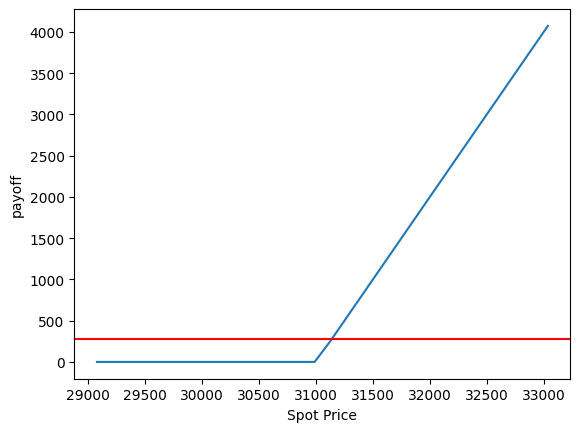

net premium 280.5087
premium 307.34569999999997
Risk Reward 13.518753963780805
probal 0.4666666666666667
lowest possible premium 0.0
max risk 1.0
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.354938299444444
mean delta1.0220588235293319e-05
min theta -1311.386
min vega -18.869999999999997
P_26000_-4__P_29000_2__C_31000_2__C_34000_-3


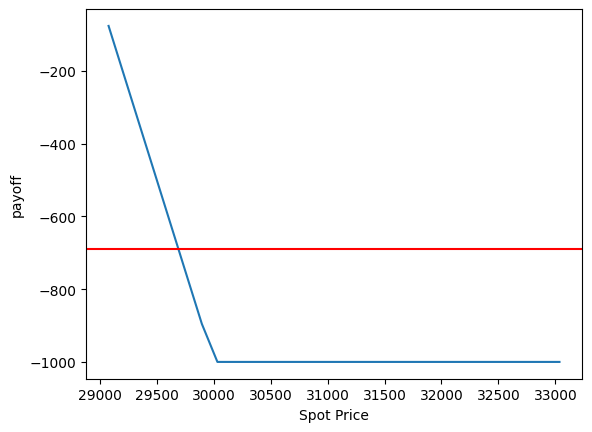

net premium -688.2584000000002
premium 1405.2332
Risk Reward 1.963503427197397
probal 0.16666666666666666
lowest possible premium -1000.0000000000002
max risk 0.45294267385621445
worst case, vol: 0.85 price: 31943.8589 daysTillExpir: 0.0
best case, vol: 1.15 price: 29076.1527 daysTillExpir: 2.354938299444444
mean delta2.3345588235301138e-06
min theta -572.796
min vega -7.480700000000001
P_27000_1__P_28000_-1__C_29000_-1__C_30000_1


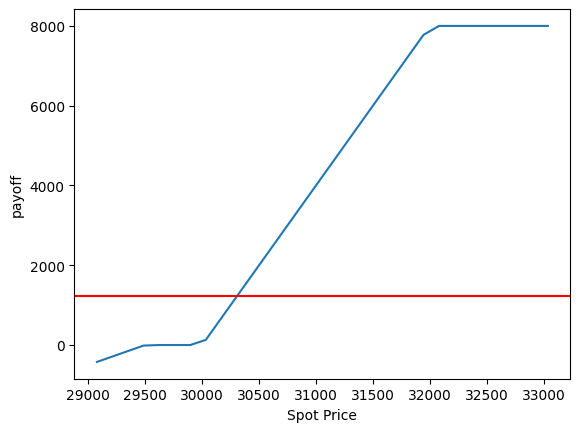

net premium 1227.0043
premium 1659.8303
Risk Reward 4.102728373646669
probal 0.6666666666666666
lowest possible premium -423.8473
max risk 1.345432611768353
worst case, vol: 0.85 price: 29076.1527 daysTillExpir: 0.0
best case, vol: 1.15 price: 32080.4164 daysTillExpir: 2.3549382878935186
mean delta7.297794117646377e-06
min theta -2144.6297
min vega -40.0439
P_27500_3__P_29500_-1__C_30000_4__C_32000_-4


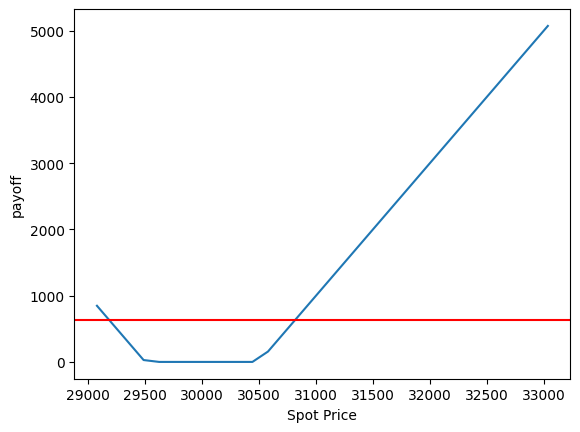

net premium 631.4379
premium 658.2749
Risk Reward 7.033469007799501
probal 0.6
lowest possible premium 0.0
max risk 1.0
worst case, vol: 0.85 price: 29622.3825 daysTillExpir: 0.0
best case, vol: 1.15 price: 33036.3184 daysTillExpir: 2.354938299444444
mean delta1.7132352941177523e-05
min theta -1362.7633999999998
min vega -21.4748
P_26000_-4__P_29500_2__C_30500_2__C_34000_-3


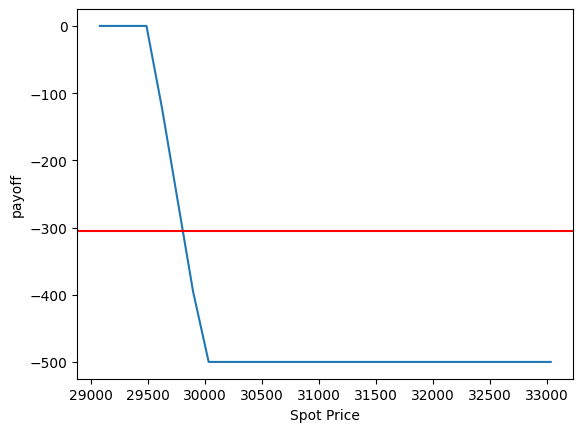

net premium -305.9129
premium 1022.8877
Risk Reward 1.5761629701304187
probal 0.2
lowest possible premium -500.0000000000002
max risk 0.6344521594218494
worst case, vol: 0.85 price: 31943.8589 daysTillExpir: 0.0
best case, vol: 1.15 price: 29485.825 daysTillExpir: 2.354938299444444
mean delta2.830882352941681e-06
min theta -574.3849
min vega -4.0737000000000005
P_27000_1__P_27500_-1__C_29500_-1__C_30000_1


In [21]:
'''
The plotted graph consists of two lines: a blue line representing the payoff curve and a red line 
representing the net premium.

The blue line represents the payoff curve, which depicts the potential profit or loss at expiration 
for the option combination. It shows how the payoff varies with different underlying asset prices. 
The shape of the curve provides insights into the risk and potential returns of the option combination.

The red line represents the net premium, which is the total premium paid or received for the option 
combination. It indicates the initial cost or income associated with entering the option positions.

By visualizing the payoff curve and net premium, you can gain a better understanding of the potential 
outcomes and financial implications of the option combination under different market scenarios. 
This can assist in evaluating the risk-reward profile and making informed decisions regarding option 
trading strategies.
'''
for para in temp.para[:5]:
    model.model_plot(para)

In [25]:
#temp.to_csv('7.21_28.9k-35k.csv',index=False)